In [1]:
from models import get_encoder
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import torch

# Here you could set the panderm checkpoint according your path
class Args:
        pretrained_checkpoint = 'path_to_checkpoint/panderm_ll_data6_checkpoint-499.pth'

args = Args()
model, eval_transform = get_encoder(args, model_name = "PanDerm_Large_LP")
_ = model.eval()

# For single image's feature extraction
img = Image.open('path_to_image/Acne and Rosacea Photos/07PerioralDermEye.jpg')
img_t = eval_transform(img).unsqueeze(0)
x = model.forward_features(img_t, is_train=False)
x = x.squeeze().cpu().detach().numpy()

x.shape

/mnt/hdd/sda/xjli/miniconda3/envs/PanDerm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading model checkpoint


/mnt/hdd/sda/xjli/miniconda3/envs/PanDerm/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      

In [2]:
class DermDataset(Dataset):
    """Custom dermatology dataset"""
    
    def __init__(self, csv_path, transform=None):
        """
        Args:
            csv_path: Path to CSV file
            transform: Image preprocessing function
        """
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['image_path']
        diag = self.df.iloc[idx]['diag']
        
        # Load image
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank image as fallback
            img = Image.new('RGB', (224, 224))
        
        # Apply transformation
        if self.transform:
            img = self.transform(img)
        
        return {
            'image': img,
            'diag': diag,
            'path': img_path,
            'index': idx
        }


def extract_features(model, dataloader, device='cuda', output_path='features.npz'):
    """
    Batch feature extraction
    
    Args:
        model: Pretrained model
        dataloader: Data loader
        device: Device ('cuda' or 'cpu')
        output_path: Path to save features
    
    Returns:
        features: Feature array
        paths: List of image paths
    """
    model = model.to(device)
    model.eval()
    
    all_features = []
    all_diags = []
    all_paths = []
    all_indices = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            images = batch['image'].to(device)
            diags = batch['diag']
            paths = batch['path']
            indices = batch['index'].numpy()
            
            # Extract features
            features = model.forward_features(images, is_train=False)
            features = features.cpu().numpy()
            
            all_features.append(features)
            all_diags.extend(diags)
            all_paths.extend(paths)
            all_indices.append(indices)
    
    # Concatenate all batches
    all_features = np.concatenate(all_features, axis=0)
    all_indices = np.concatenate(all_indices, axis=0)
    
    # Save features
    if output_path:
        np.savez(
            output_path,
            features=all_features,
            diags=all_diags,
            paths=all_paths,
            indices=all_indices
        )
        print(f"\nFeatures saved to {output_path}")
    
    print(f"Feature shape: {all_features.shape}")
    
    return all_features, all_diags, all_paths

In [3]:
batch_size = 32
num_workers = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
csv_path = 'path_to_data_csv/daffodil-5-zero-shot-test.csv' # Path to your csv

In [4]:
pd.read_csv(csv_path)[['image_path', 'diag']] # Please include these two column in your csv

,image_path,diag
0,/home/share/Uni_Eval/Daffodil/Vitiligo/hue-150...,vitiligo
1,/home/share/Uni_Eval/Daffodil/Vitiligo/hue-100...,vitiligo
2,/home/share/Uni_Eval/Daffodil/Vitiligo/superpi...,vitiligo
3,/home/share/Uni_Eval/Daffodil/Vitiligo/padd-01...,vitiligo
4,/home/share/Uni_Eval/Daffodil/Vitiligo/hue-200...,vitiligo
...,...,...
1905,/home/share/Uni_Eval/Daffodil/Nail_psoriasis/s...,nail psoriasis
1906,/home/share/Uni_Eval/Daffodil/Nail_psoriasis/f...,nail psoriasis
1907,/home/share/Uni_Eval/Daffodil/Nail_psoriasis/p...,nail psoriasis
1908,/home/share/Uni_Eval/Daffodil/Nail_psoriasis/C...,nail psoriasis


In [5]:
# Load dataset
dataset = DermDataset(csv_path, transform=eval_transform)
print(f"Dataset size: {len(dataset)}")

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True if device == 'cuda' else False
)

print("Extracting features...")
features, diags, paths = extract_features(
    model, 
    dataloader, 
    device=device,
    output_path=None
)

Dataset size: 1910
Extracting features...


Extracting features: 100%|██████████| 60/60 [00:13<00:00,  4.41it/s]

Feature shape: (1910, 1024)


In [6]:
features.shape

(1910, 1024)

In [7]:
df = pd.read_csv(csv_path)

In [8]:
!pip install umap-learn

/mnt/hdd/sda/xjli/miniconda3/envs/PanDerm/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


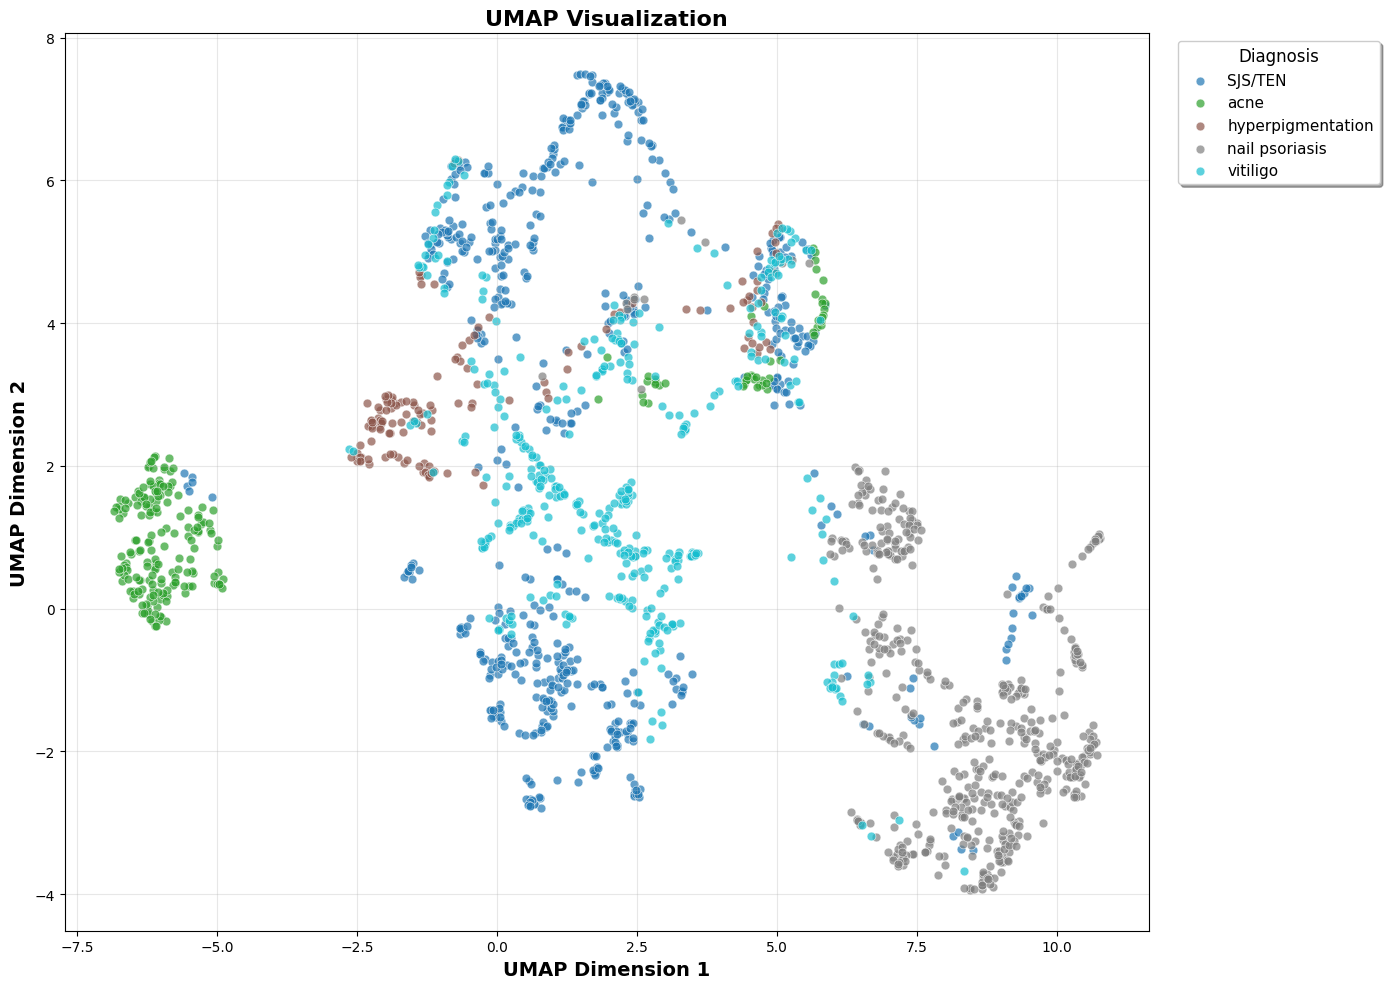

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

umap = UMAP(n_neighbors=10, min_dist=0.2, random_state=42)
embedding = umap.fit_transform(features)

plt.figure(figsize=(14, 10))

unique_diags = np.unique(diags)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_diags)))

# Plot each diagnosis separately to show in legend
for i, diag in enumerate(unique_diags):
    mask = np.array([d == diag for d in diags])
    plt.scatter(
        embedding[mask, 0], 
        embedding[mask, 1],
        c=[colors[i]],
        label=diag,           # This shows diagnosis name in legend
        alpha=0.7,
        s=40,
        edgecolors='white',
        linewidth=0.5
    )

plt.xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold')
plt.ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold')
plt.title('UMAP Visualization', fontsize=16, fontweight='bold')

plt.legend(
    title='Diagnosis',
    bbox_to_anchor=(1.02, 1),  # Place legend outside plot
    loc='upper left',
    fontsize=11,
    title_fontsize=12,
    frameon=True,
    shadow=True
)

plt.grid(True, alpha=0.3)
plt.tight_layout()